# Run hacked AlphaFold2 on the designed bound states

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties
running on node: dig159


### Set working directory to the root of the crispy_shifty repo
Note: We want to use perlmutter

In [ ]:
os.chdir("/global/cfs/cdirs/m3962/projects/crispy_shifty")

### Fix the paths
Necessary because we are on perlmutter

In [3]:
from crispy_shifty.utils.io import fix_path_prefixes

pairs = os.path.join(
    os.getcwd(), "projects/crispy_shifties/02_mpnn_bound_states/mpnn_states.pair"
)
new_pairs = fix_path_prefixes(
    find="/mnt/home/pleung",
    replace="/global/cfs/cdirs/m3962",
    file=pairs,
    overwrite=True,
)

/global/cfs/cdirs/m3962/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Run AF2 on the designed bound states
TODO

In [4]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "03_fold_bound_states"
design_list_file = os.path.join(
    os.getcwd(),
    "projects/crispy_shifties/02_mpnn_bound_states/mpnn_states.pair",
)
output_path = os.path.join(f"/pscratch/sd/p/pleung/{simulation_name}")

options = " ".join(
    [
        "out:level 200",
    ]
)
extra_kwargs = {"models": "1"}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
)

Run the following command with your desired environment active:
sbatch -a 1-$(cat /pscratch/sd/p/pleung/03_fold_bound_states/tasks.cmds | wc -l) /pscratch/sd/p/pleung/03_fold_bound_states/run.sh


In [5]:
# !sbatch -a 1-$(cat /global/cfs/cdirs/m3962/projects/crispy_shifty/projects/crispy_shifties/03_fold_bound_states/tasks.cmds | wc -l) /global/cfs/cdirs/m3962/projects/crispy_shifty/projects/crispy_shifties/03_fold_bound_states/run.sh

### Set working directory to the root of the crispy_shifty repo
Note: We rsync the perlmutter results, now back on the digs

In [2]:
os.chdir("/home/pleung/projects/crispy_shifty")  # TODO

### Collect scorefiles of designed bound states and concatenate
TODO change to projects dir

In [3]:
sys.path.insert(0, "~/projects/crispy_shifty")  # TODO
from crispy_shifty.utils.io import collect_score_file

simulation_name = "03_fold_bound_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

https://docs.anaconda.com/anaconda/install



/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile
TODO change to projects dir  
TODO might have to switch to a dask accelerated approach for production

In [4]:
sys.path.insert(0, "~/projects/crispy_shifty")  # TODO
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [6]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [7]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"]
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1305, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

### Remove score terms we don't care about

In [8]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))

2610


In [9]:
sample_df = sample_df[[term for term in sample_df.columns if "mpnn_seq" not in term]]

sample_df.head()

,bb_clash,best_average_DAN_plddts,best_average_plddts,best_model,best_ptm,best_rmsd_to_input,buns_parent,cms_AcB,cms_AnAc,cms_AnAcB,...,shift,ss_sc,state,time,tol,topo,total_length,total_score,trimmed_length,type
/pscratch/sd/p/pleung/03_fold_bound_states/decoys/0051/03_fold_bound_states_9281b0254d3844de9e5b4b4a7b992095.pdb.bz2,134.170090,0.936035,95.248400,2,0.875449,0.892910,3.0,188.524139,459.312073,456.707092,...,6,0.761332,JHR_bd1_1533_p_3_s_6_d_2,3214.946123,1.264600,HHHHH,148.0,-224.293781,119,monomer_ptm
/pscratch/sd/p/pleung/03_fold_bound_states/decoys/0051/03_fold_bound_states_6bc3853b5c8449109f7129396347b921.pdb.bz2,163.681000,0.992676,96.000677,5,0.907670,0.851270,1.0,331.750549,518.819763,587.871399,...,6,0.741315,DHR26_p_4_s_6_d_3,7088.466465,0.405094,HHHHHHHH,242.0,27.101161,207,monomer_ptm
/pscratch/sd/p/pleung/03_fold_bound_states/decoys/0051/03_fold_bound_states_f651cab6b85645bd92c414c187da3f64.pdb.bz2,238.570618,0.927246,96.164213,2,0.895098,1.073741,5.0,230.447296,290.521027,548.575684,...,-3,0.744646,DHR54_p_4_s_-3_d_5,4432.603781,5.414459,HHHHHHHH,203.0,-384.623770,171,monomer_ptm
/pscratch/sd/p/pleung/03_fold_bound_states/decoys/0051/03_fold_bound_states_858bab50149943bb8a3f6f4823769578.pdb.bz2,159.356201,0.821777,92.232918,2,0.872556,1.137826,1.0,193.815353,387.129517,482.149811,...,-3,0.671939,DHR3_p_4_s_-3_d_3,4449.986776,1.411230,HHHHHHHH,201.0,-430.710840,167,monomer_ptm
/pscratch/sd/p/pleung/03_fold_bound_states/decoys/0051/03_fold_bound_states_9754a77bb16b4e94b45e8ae94e50419c.pdb.bz2,179.063385,0.999023,94.380690,5,0.889773,1.011188,4.0,293.448090,333.873962,599.043335,...,3,0.754108,DHR15_p_4_s_3_d_3,4652.684446,1.124594,HHHHHHHH,210.0,-328.074003,181,monomer_ptm


In [10]:
from crispy_shifty.plotting.utils import histplot_df, pairplot_df

to_plot = [
    "best_average_plddts",
    "best_model",
    "best_ptm",
    "best_rmsd_to_input",
    "cms_AcB",
    "cms_AnAc",
    "cms_AnAcB",
    "cms_AnB",
    "designed_by",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_interaction_AB",
    "mean_pae_interaction_BA",
    "mean_pae_intra_chain",
    "mean_pae_intra_chain_A",
    "mean_pae_intra_chain_B",
    "mean_plddt",
    "mismatch_probability_parent",
    "pTMscore",
    "packstat_parent",
    "pdb",
    "recycles",
    "rmsd_to_reference",
    "sap_parent",
    "sc_AcB",
    "sc_AnAc",
    "sc_AnAcB",
    "sc_AnB",
    "sc_all_parent",
    "score_per_res",
    "score_per_res_parent",
    "ss_sc",
    "state",
    "topo",
]
print(to_plot)

['best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'pTMscore', 'packstat_parent', 'pdb', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'score_per_res', 'score_per_res_parent', 'ss_sc', 'state', 'topo']


### Plot before and after interface design

6it [00:00, 12.30it/s]


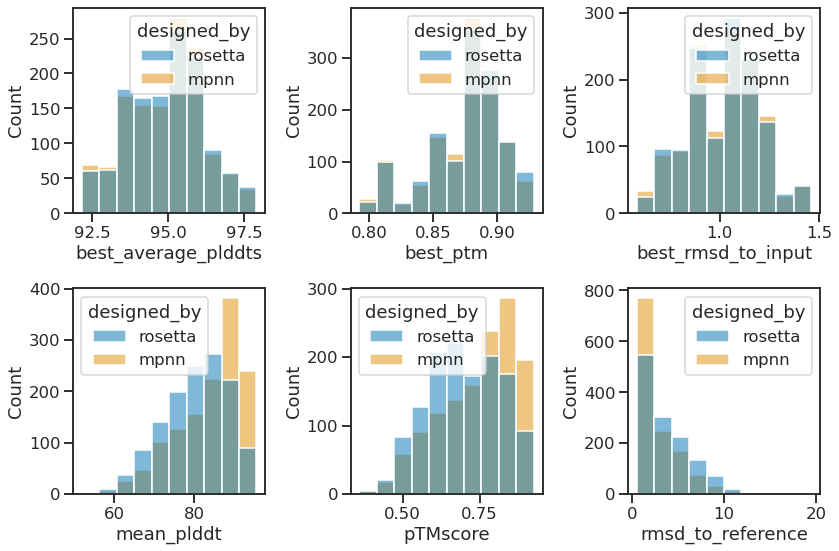

In [11]:
cols = [
    "best_average_plddts",
    "best_ptm",
    "best_rmsd_to_input",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores.png"))

6it [00:00,  8.76it/s]


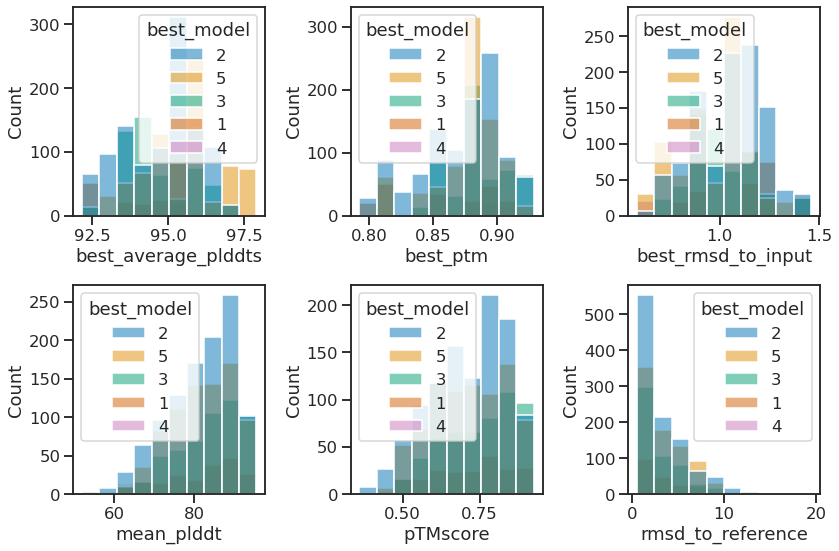

In [12]:
sample_df["best_model"] = sample_df["best_model"].astype(str)
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="best_model",
)

6it [00:00, 10.11it/s]


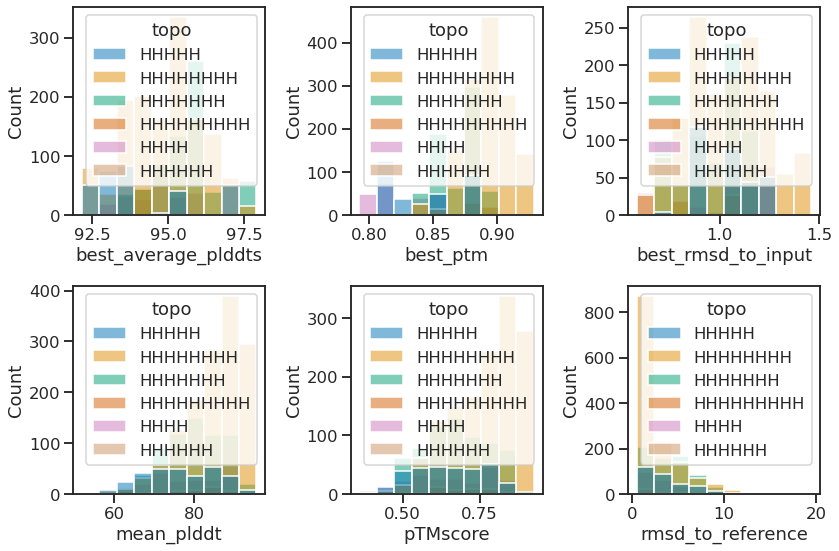

In [13]:
sample_df["best_model"] = sample_df["best_model"].astype(str)
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="topo",
)

<Figure size 1728x1728 with 0 Axes>

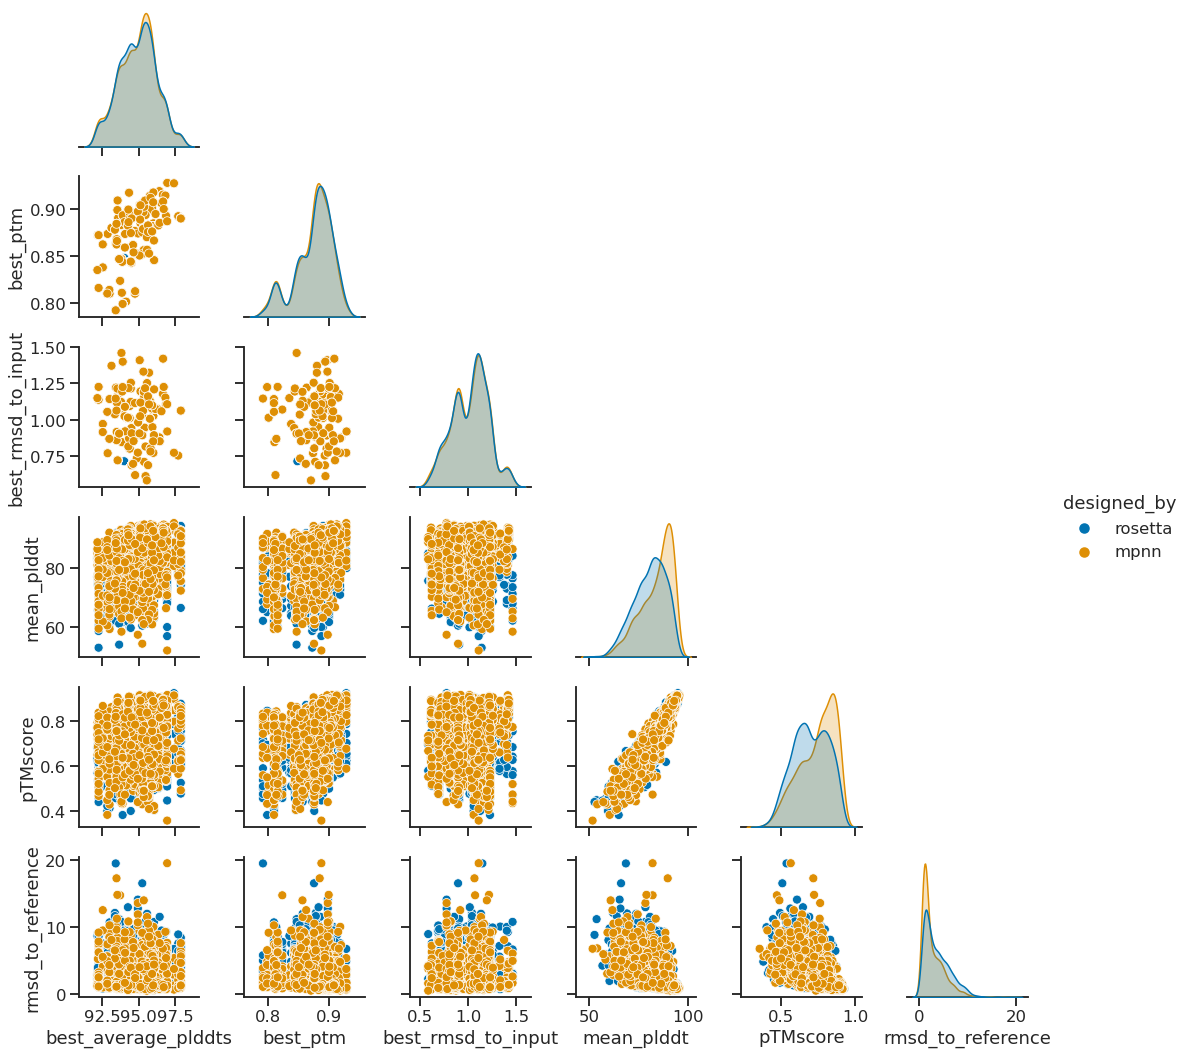

In [14]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_paired.png"))

### Plot interface correllations

6it [00:00, 22.64it/s]


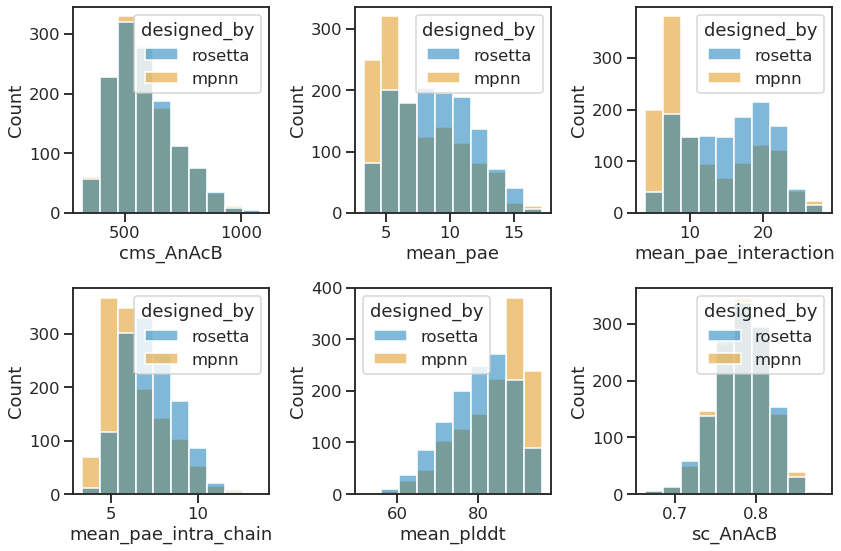

In [15]:
cols = [
    "cms_AnAcB",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "sc_AnAcB",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "interface_scores.png"))

6it [00:00, 13.26it/s]


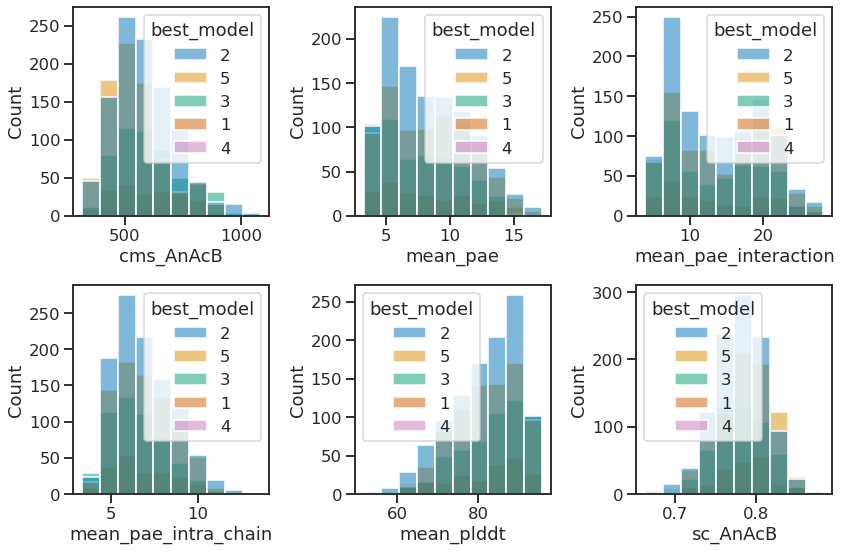

In [16]:
sample_df["best_model"] = sample_df["best_model"].astype(str)
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="best_model",
)

6it [00:00,  7.91it/s]


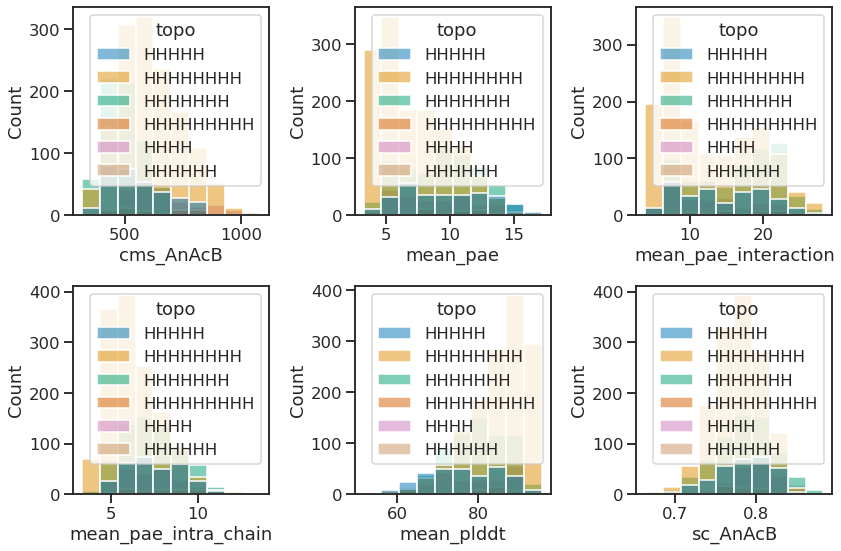

In [17]:
sample_df["best_model"] = sample_df["best_model"].astype(str)
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="topo",
)

<Figure size 1728x1728 with 0 Axes>

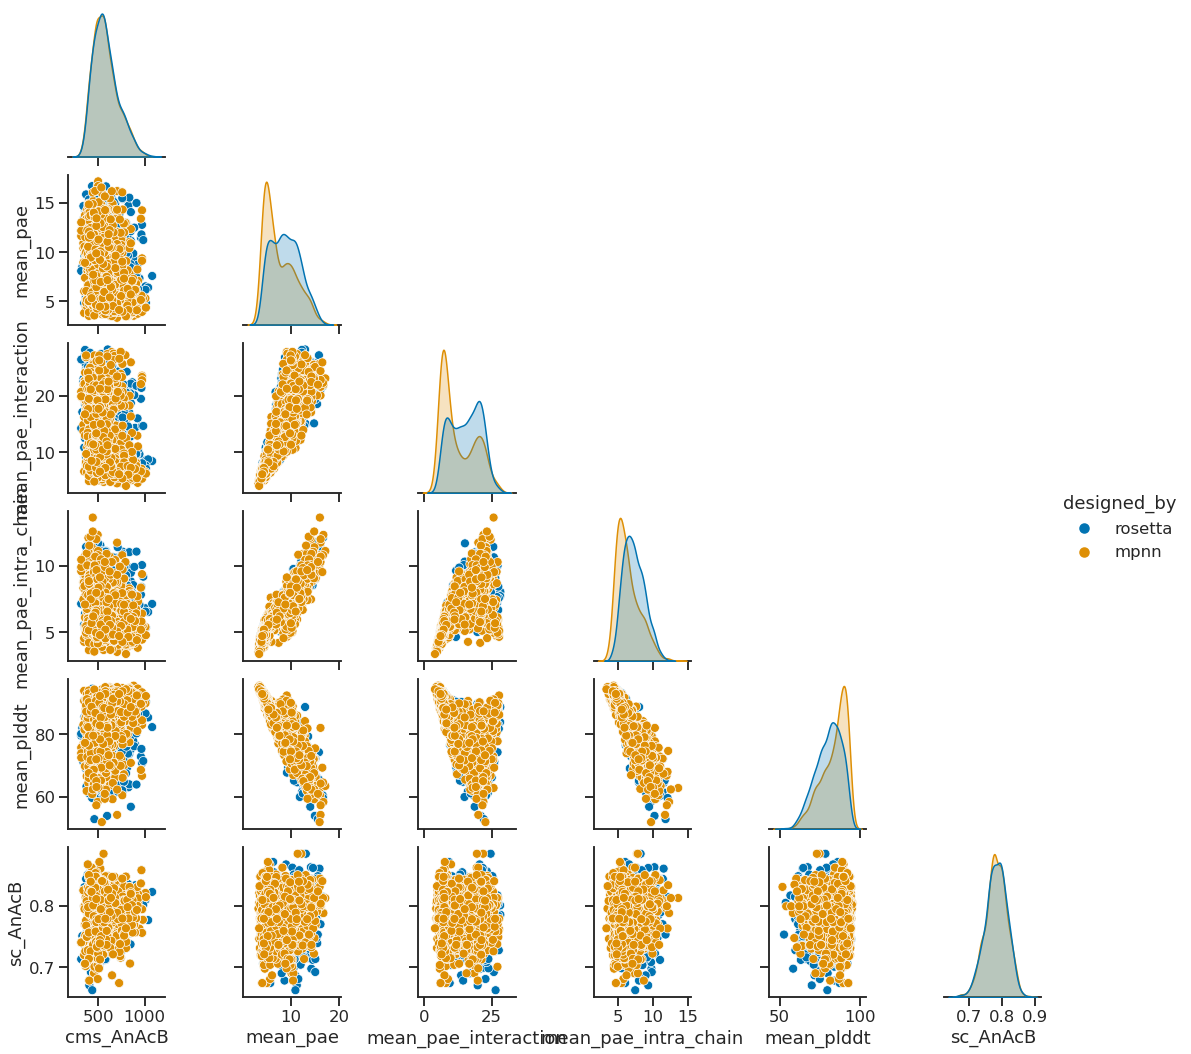

In [18]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "interface_scores_paired.png"))

### Plot before and after for other scores

10it [00:00, 14.92it/s]


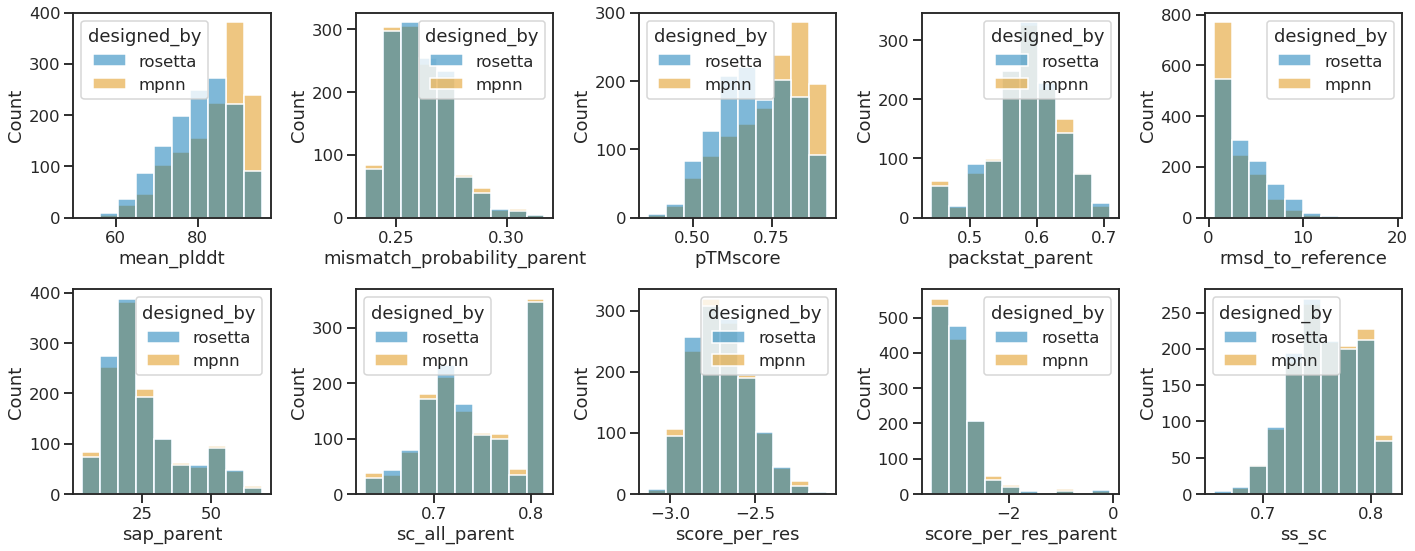

In [19]:
cols = [
    "mean_plddt",
    "mismatch_probability_parent",
    "pTMscore",
    "packstat_parent",
    "rmsd_to_reference",
    "sap_parent",
    "sc_all_parent",
    "score_per_res",
    "score_per_res_parent",
    "ss_sc",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_other_scores.png"))

10it [00:00, 11.87it/s]


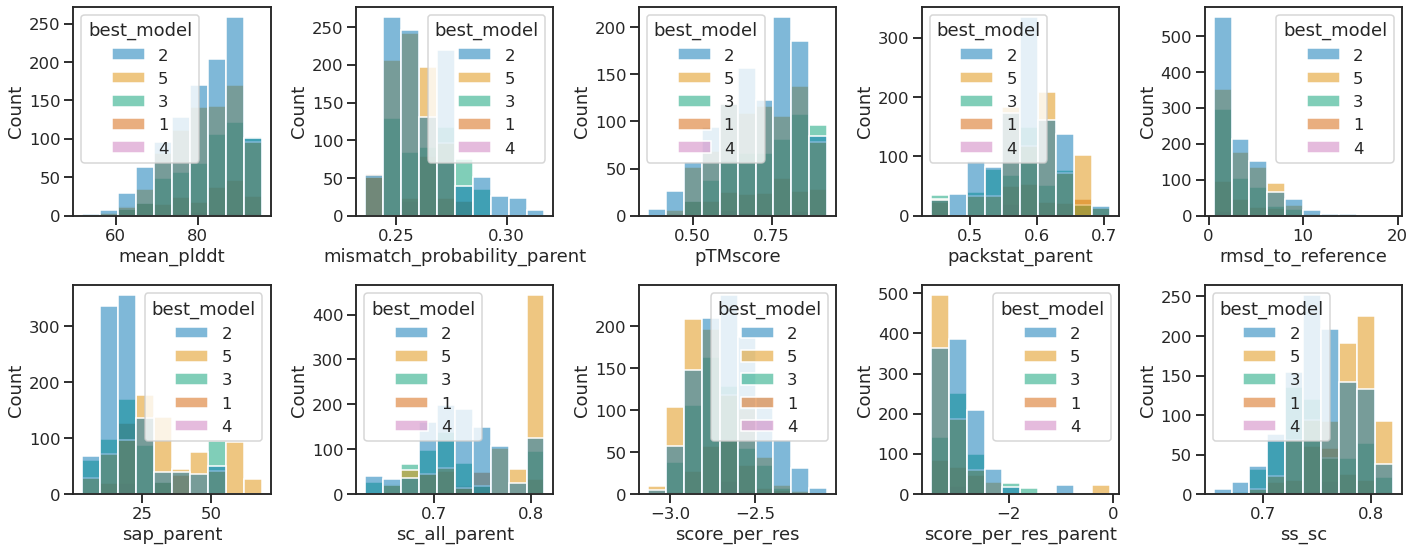

In [20]:
sample_df["best_model"] = sample_df["best_model"].astype(str)
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="best_model",
)

10it [00:01,  8.57it/s]


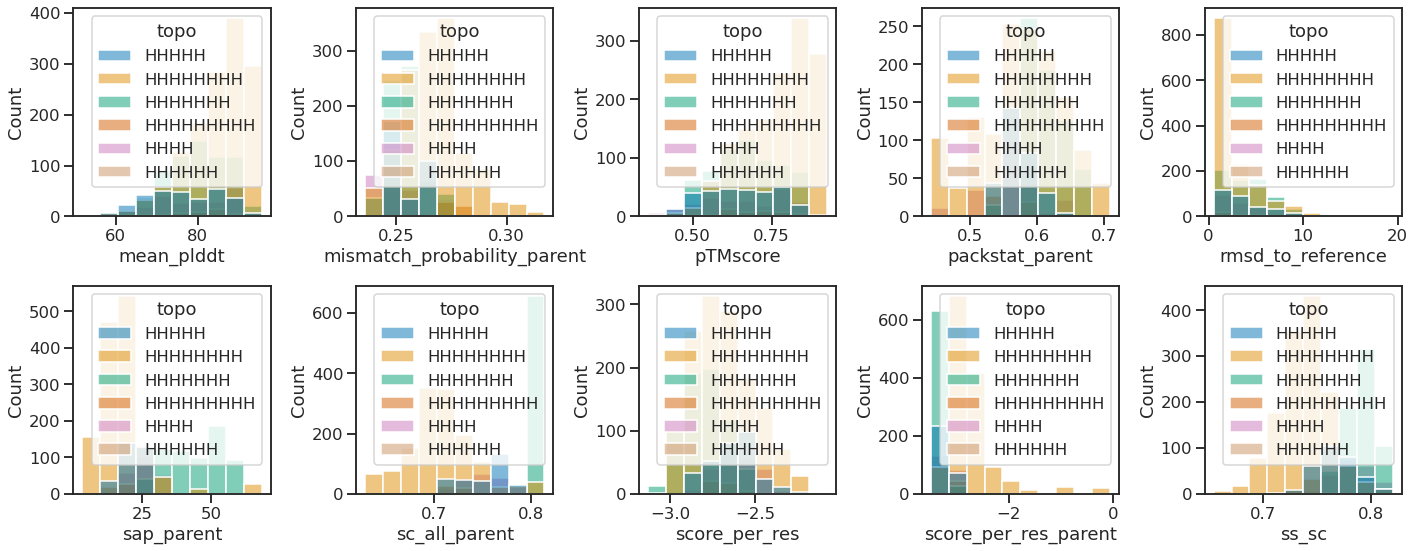

In [21]:
sample_df["best_model"] = sample_df["best_model"].astype(str)
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="topo",
)

<Figure size 2880x2880 with 0 Axes>

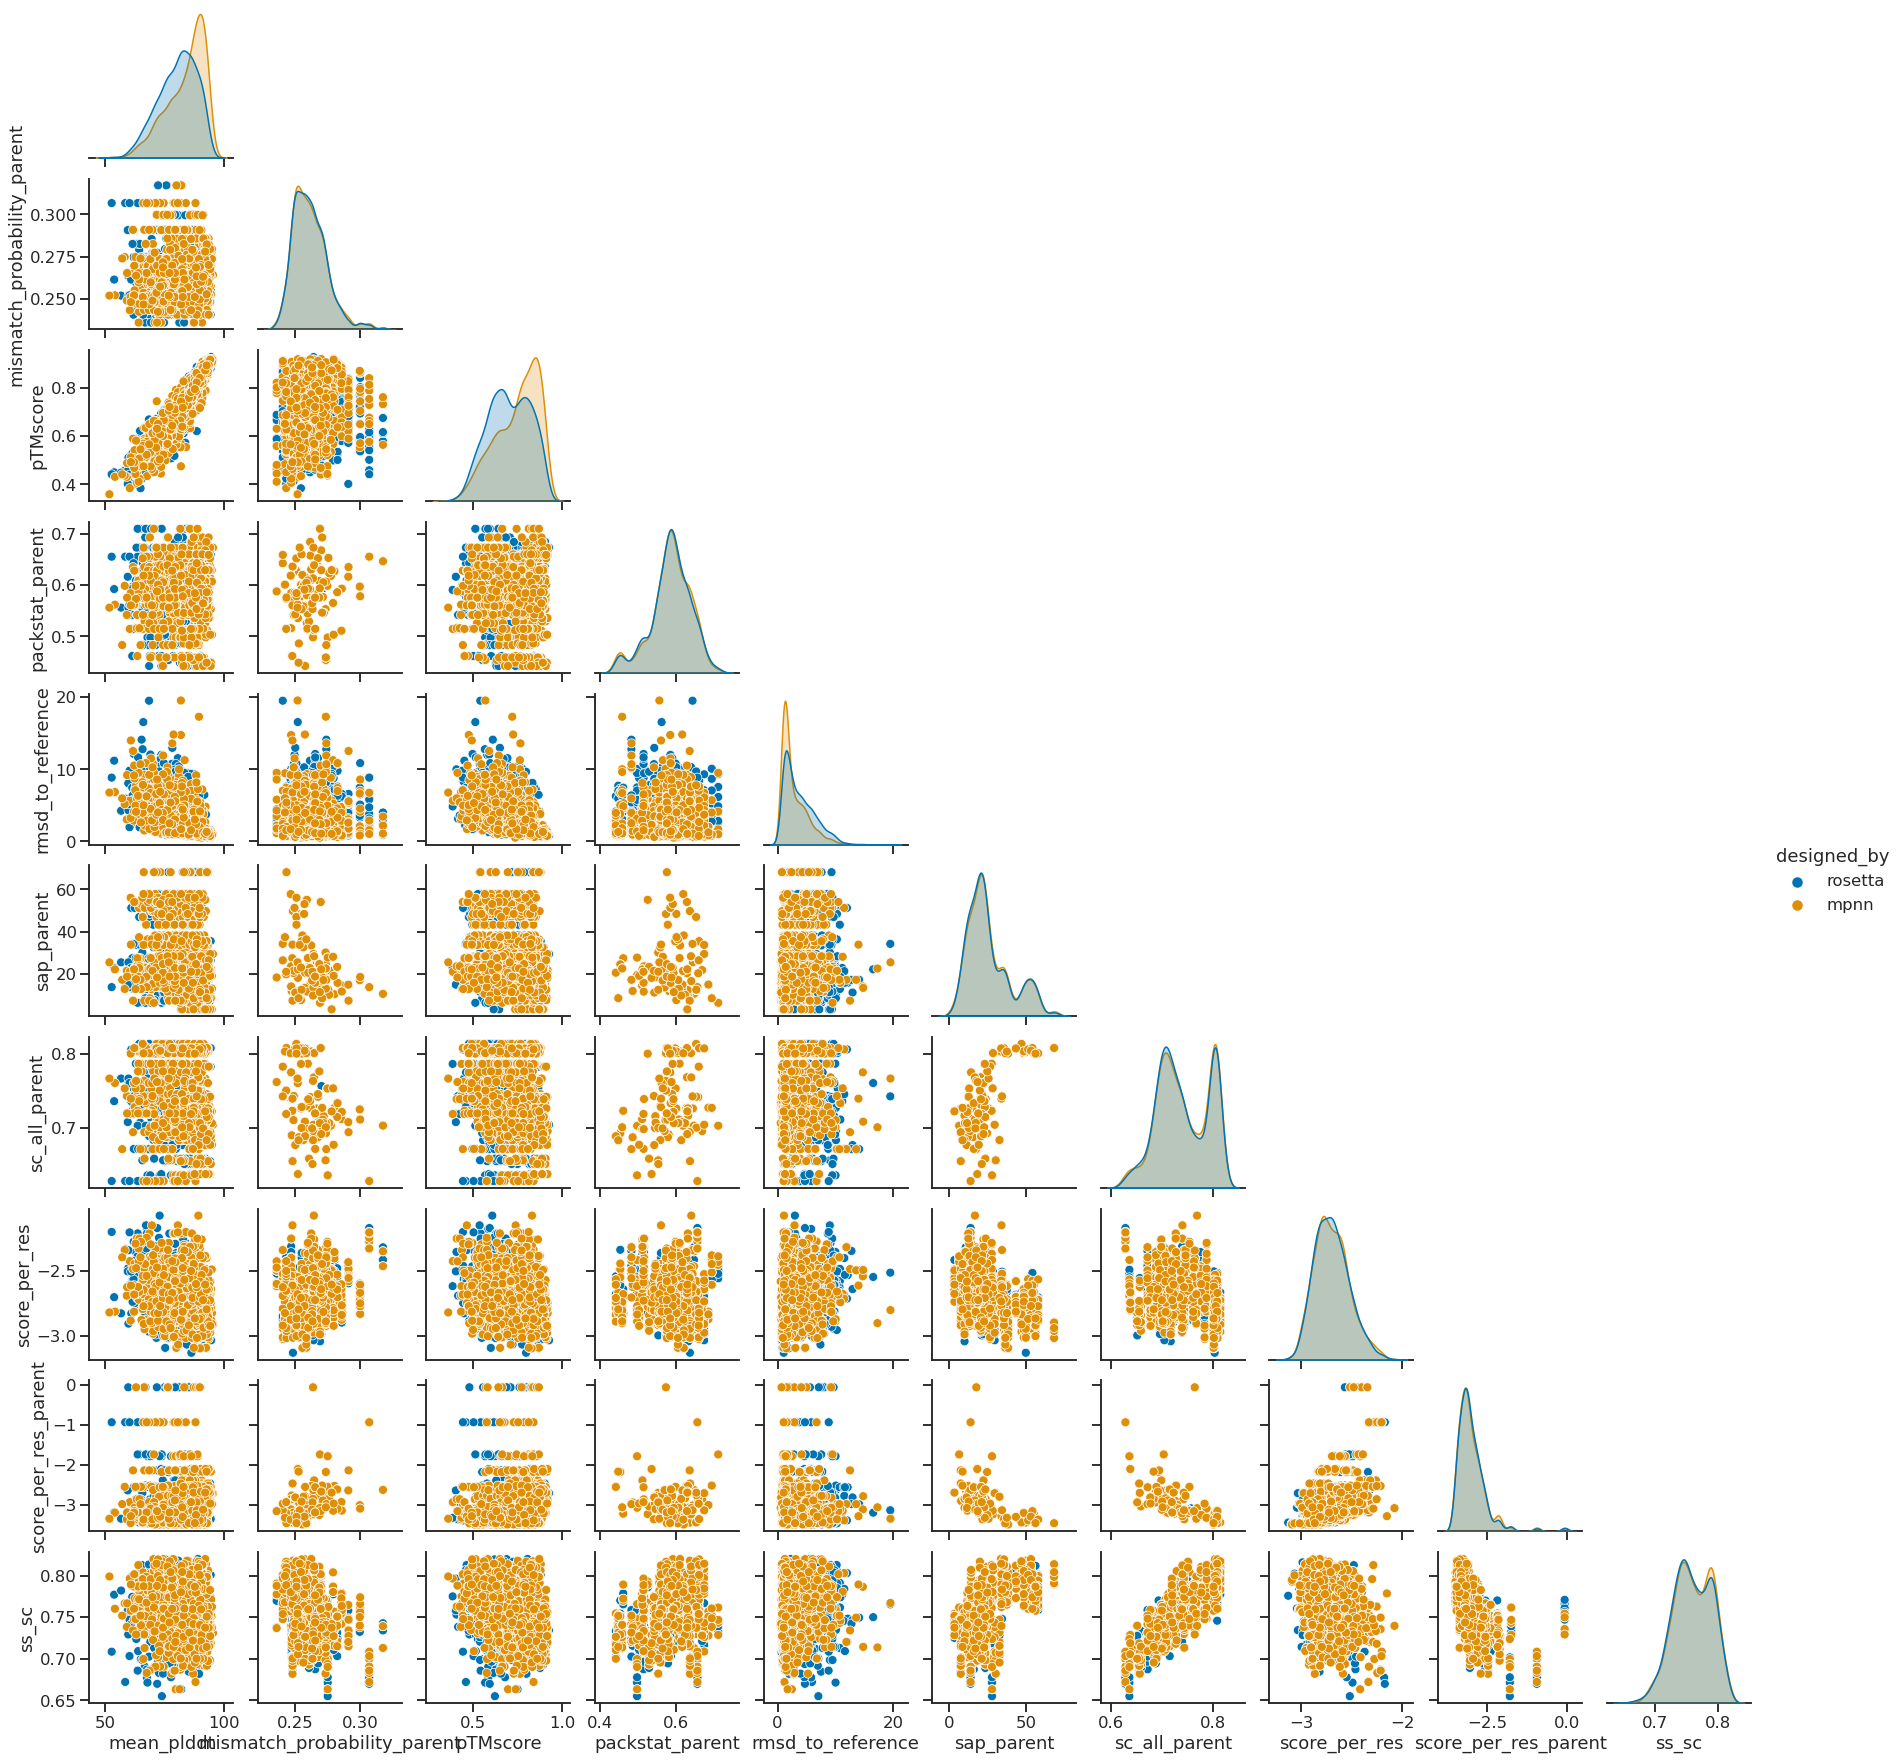

In [22]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_other_scores_paired.png"))

### Filter the whole df

In [23]:
query = "mean_plddt > 90 and mean_pae_interaction < 5 and rmsd_to_reference < 1.75"

filtered = scores_df.query(query)
len(filtered)

1130

### Plot topo and scaffold_type fraction before and after

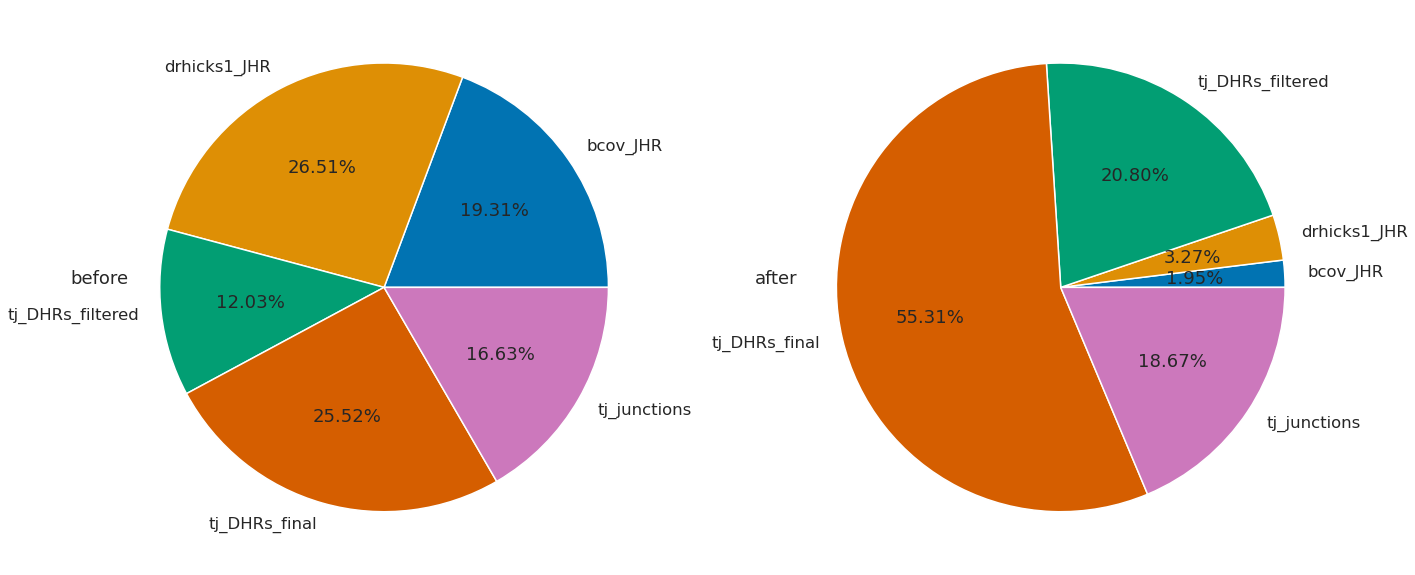

In [24]:
(
    fig,
    (ax1, ax2),
) = plt.subplots(ncols=2, figsize=(20, 10), tight_layout=True)
scores_df.groupby("scaffold_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
ax1.set_ylabel("before", rotation=0)
filtered.groupby("scaffold_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax2)
ax2.set_ylabel("after", rotation=0)

plt.savefig(os.path.join(output_path, "filtering_effect_scaffold_type.png"))

### Save a list of outputs

In [25]:
simulation_name = "03_fold_bound_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

with open(os.path.join(output_path, "folded_states.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

  0%|          | 0/1130 [00:00<?, ?it/s]

### Prototyping blocks

test `fold_bound_state`

In [ ]:
%%time 
from operator import gt, lt
import pyrosetta

filter_dict = {
    "mean_plddt": (gt, 85.0),
    "rmsd_to_reference": (lt, 2.2),
    "mean_pae_interaction": (lt, 10.0),
}

rank_on = "mean_plddt"
prefix = "mpnn_seq"

pyrosetta.init()


sys.path.insert(0, "~/projects/crispy_shifty/") # TODO projects
from crispy_shifty.protocols.folding import fold_bound_state

t = fold_bound_state(
        None,
        **{
            'fasta_path': '/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/02_mpnn_bound_states/fastas/0000/02_mpnn_bound_states_25a76fae39514121922e2b477b5b9813.fa',
            "filter_dict": filter_dict,
            "models": [1], # TODO
            'pdb_path': '/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/02_mpnn_bound_states/decoys/0000/02_mpnn_bound_states_25a76fae39514121922e2b477b5b9813.pdb.bz2',
            'prefix': prefix,
            'rank_on': rank_on,
#             'fasta_path': 'bar.fa',
#             "models": [1, 2], # TODO
#             'pdb_path': 'foo.pdb.bz2',
            
        }
)
for i, tppose in enumerate(t):
    tppose.pose.dump_pdb(f"{i}.pdb")

In [ ]:
tppose.pose.scores

test `generate_decoys_from_pose`

In [ ]:
from operator import gt, lt
from crispy_shifty.protocols.folding import generate_decoys_from_pose

filter_dict = {
    "mean_plddt": (gt, 85.0),
    "rmsd_to_reference": (lt, 2.2),
    "mean_pae_interaction": (lt, 10.0),
}

rank_on = "mean_plddt"
prefix = "mpnn_seq"

tpose = tppose.pose.clone()

genr = generate_decoys_from_pose(
    tpose, prefix=prefix, rank_on=rank_on, filter_dict=filter_dict
)
for d in genr:
    print(d.sequence())